In [1]:
import interfere
import numpy as np
import matplotlib.pyplot as plt

$$
\dot{x}_i = (\lambda - x_i^2 - y_i^2)x_i -\omega y_i + \kappa A{ij} \sum_{i,j \in
n} (x_j - x_i) \\ \dot{y}_i = (\lambda - x_i^2 - y_i^2)y_i +\omega x_i
$$

In [ ]:
with open("/Users/djpassey/Code/interfere/notebooks/exp1_models.ipynb") as f:
    lines = [l.strip() for l in f.readlines()]

init_lines_bool = [
    True if l.startswith('"    initial_cond') else False for l in lines
]
init_lines = [
    l for l, is_init in zip(lines, init_lines_bool) if is_init
]
init_args = [
    [
        x.split(",")[0].strip()
        for x in l.split(":")[1:]
    ][:2]
    for l in init_lines
]

line_templ = '"    initial_conds=uniform_init_cond({min}, {max}, dim, reps),\\n",'
line_templ.format(min="2", max="3")
new_lines = lines.copy()

init_line_idx = 0
for i, is_init in enumerate(init_lines_bool):
    if is_init:
        a, b = init_args[init_line_idx]
        init_line_idx += 1
        new_lines[i] = line_templ.format(min=a, max=b)

[l for l, is_init in zip(new_lines, init_lines_bool) if is_init]




In [ ]:
with open(
    "/Users/djpassey/Code/interfere/notebooks/exp1_models_update.ipynb", "w"
    ) as f:
    f.writelines(new_lines)

In [ ]:
import pickle as pkl
import interfere

mprms = pkl.load(open("/Users/djpassey/Code/interfere/experiments/exp1/inference_methods.pkl", 'rb'))

## Working Rescomp Response to Exog

Intervention response error:  1.21120078073882
No intervention error:  3.6696367467773396  (should be higher if it works).


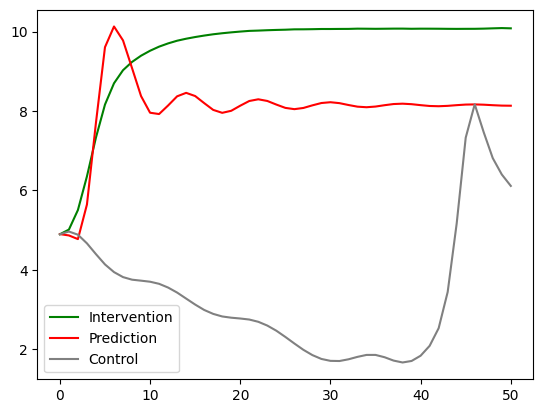

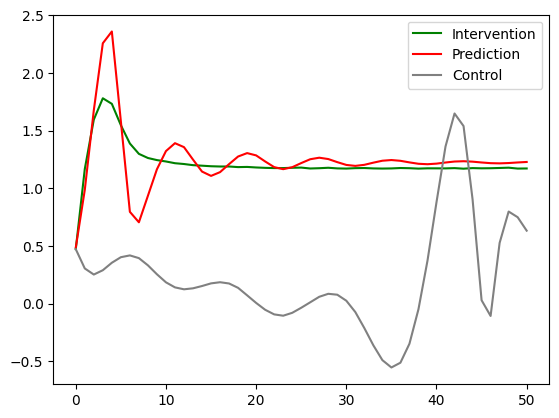

In [241]:
import interfere
import numpy as np
import matplotlib.pyplot as plt
SEED = 11

dim = 3
method_type = interfere.methods.ResComp

params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params=dict(
        # Turning off sigma makes a difference. (sigma = 0.0 v.s. sigma = 0.01)
        mu=1.81, sigma=0.01, measurement_noise_std = 0.0 * np.ones(dim),
    ),
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 2, "constants": 0.9},
    initial_conds=[2.0 * np.ones(dim)],
    start_time=0, end_time=50, dt=0.05,
    rng = np.random.default_rng(SEED)
)

Xs, X_dos, t = interfere.benchmarking.generate_counterfactual_forecasts(**params, train_per=0.95)
X, X_do = Xs[0], X_dos[0]

n_do, _ = X_do.shape
X_historic, historic_times = X[:(-n_do + 1), :], t[:(-n_do + 1)]
forecast_times = t[-n_do:]

intervention = params["intervention_type"](**params["intervention_params"])
method = method_type(**{
    **method_type.get_test_params(),
    "window": 0.25,
    "gamma": 200  # A Very high gamma is key. Does not work with lower gammas.
}) #, "maxlags": 10, "trend": "n"})

endo, exog = intervention.split_exogeneous(X_historic)
method.fit(historic_times, endo, exog)

X_do_pred = method.simulate(
    t=forecast_times,
    prior_states=X_historic,
    prior_t=historic_times,
    intervention=intervention
)

X_do_pred_endo, _ = intervention.split_exogeneous(X_do_pred)
X_do_endo, _ = intervention.split_exogeneous(X_do)
X_counter_endo, _ = intervention.split_exogeneous(X[-n_do:, :])

mse_intervened = np.mean((X_do_pred_endo - X_do_endo) ** 2) ** 0.5
mse_no_intervention = np.mean((X_do_pred_endo - X_counter_endo) ** 2) ** 0.5


print("Intervention response error: ", mse_intervened)
print(
    "No intervention error: ", 
    mse_no_intervention, 
    " (should be higher if it works)."
)

for i in range(dim - 1):
    plt.plot(X_do_endo[:, i], c="g", label="Intervention")
    plt.plot(X_do_pred_endo[:, i], c="red", label="Prediction")

    plt.plot(X_counter_endo[:, i], c="gray", label="Control")
    plt.legend()
    plt.show()

## Exploring with ResComp

Intervention response error:  1.8330966841784764
No intervention error:  3.5396850902122146  (should be higher if it works).


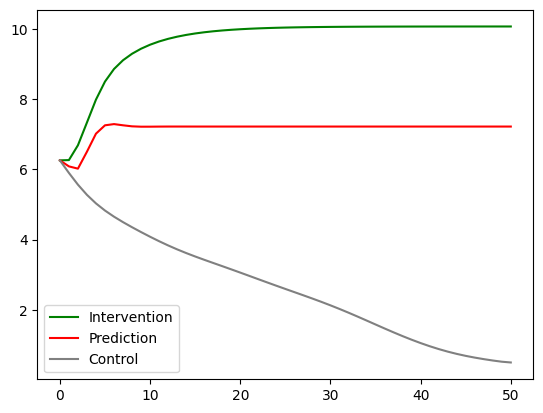

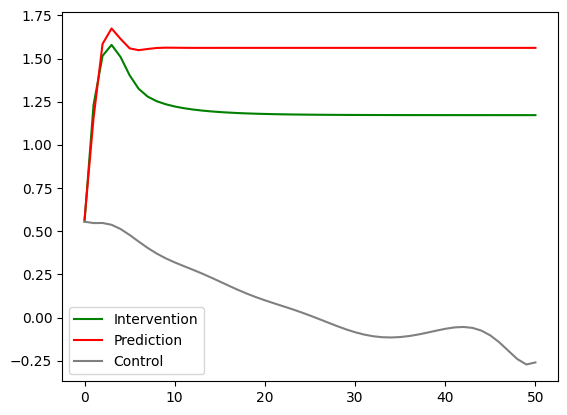

In [269]:
import interfere
import numpy as np
import matplotlib.pyplot as plt
SEED = 11

dim = 3
method_type = interfere.methods.ResComp

params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params=dict(
        # Turning off sigma makes a difference.
        mu=1.81, sigma=0.0, measurement_noise_std = 0.0 * np.ones(dim),
    ),
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 2, "constants": 0.9},
    initial_conds=[-1.1 * np.ones(dim)],
    start_time=0, end_time=50, dt=0.05,
    rng = np.random.default_rng(SEED)
)

Xs, X_dos, t = interfere.benchmarking.generate_counterfactual_forecasts(**params, train_per=0.95)
X, X_do = Xs[0], X_dos[0]

n_do, _ = X_do.shape
X_historic, historic_times = X[:(-n_do + 1), :], t[:(-n_do + 1)]
forecast_times = t[-n_do:]

intervention = params["intervention_type"](**params["intervention_params"])
method = method_type(**{
    **method_type.get_test_params(),
    "window": 0.25,
    "gamma": 300
}) #, "maxlags": 10, "trend": "n"})

endo, exog = intervention.split_exogeneous(X_historic)
method.fit(historic_times, endo, exog)

X_do_pred = method.simulate(
    t=forecast_times,
    prior_states=X_historic,
    prior_t=historic_times,
    intervention=intervention
)

X_do_pred_endo, _ = intervention.split_exogeneous(X_do_pred)
X_do_endo, _ = intervention.split_exogeneous(X_do)
X_counter_endo, _ = intervention.split_exogeneous(X[-n_do:, :])

mse_intervened = np.mean((X_do_pred_endo - X_do_endo) ** 2) ** 0.5
mse_no_intervention = np.mean((X_do_pred_endo - X_counter_endo) ** 2) ** 0.5


print("Intervention response error: ", mse_intervened)
print(
    "No intervention error: ", 
    mse_no_intervention, 
    " (should be higher if it works)."
)

for i in range(dim - 1):
    plt.plot(X_do_endo[:, i], c="g", label="Intervention")
    plt.plot(X_do_pred_endo[:, i], c="red", label="Prediction")

    plt.plot(X_counter_endo[:, i], c="gray", label="Control")
    plt.legend()
    plt.show()

In [2]:
import numpy as np
np.round(1.111, decimals=0)

1.0

In [3]:
t = np.arange(0, 3, 0.2)

In [4]:
dt = t[1] - t[0]
start_int = np.round(t[0] / dt, decimals=0)
end_int = start_int + len(t)
discrete_t = np.arange(start_int, end_int)

In [6]:
len(discrete_t) == len(t)

True

In [1]:
import interfere

import numpy as np
import matplotlib.pyplot as plt

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing GenerativeForecasters on Noise

In [117]:
N = 100
SEED = 10
method = interfere.methods.SINDY()#gamma=100, rng=np.random.default_rng(SEED), map_initial="activ_f")
prior_t = np.arange(N)
X = np.random.rand(N, 10)
method.fit(prior_t, X)
model = interfere.dynamics.GenerativeForecaster(method, None, None)

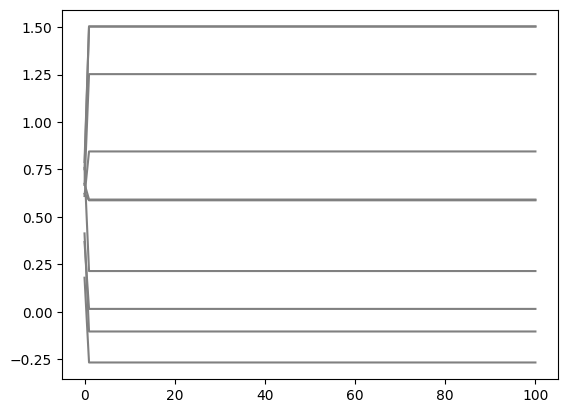

In [118]:
M = 100
#X_do = model.simulate(np.arange(N - 1, N + M), prior_states=X, prior_t=prior_t, intervention=interfere.PerfectIntervention(0, 2))
X_counter = model.simulate(np.arange(N - 1, N + M), prior_states=X, prior_t=prior_t, intervention=None)

#plt.plot(X_do, c="g")

plt.plot(X_counter, c="gray")



In [119]:
X_counter_train = X_counter[:, :]
counter_t = np.arange(X_counter_train.shape[0])
n_test = 30
fit_method = interfere.methods.SINDY()
#    gamma=100, rng=np.random.default_rng(SEED), map_initial="activ_f")

fit_method.fit(counter_t[:-n_test], X_counter_train[:-n_test, :])

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


SINDY(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
                     'x9'],
      optimizer=STLSQ())

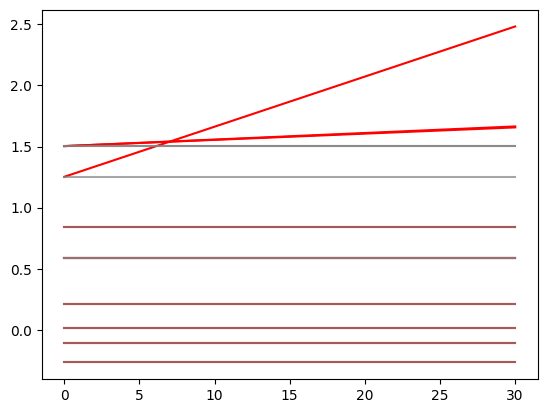

In [120]:
pred_X_counter = fit_method.predict(
    counter_t[-n_test-1:],
    prior_endog_states=X_counter_train[:-n_test, :],
    prior_t=counter_t[:-n_test])

plt.plot(pred_X_counter, c="r")
plt.plot(X_counter_train[-n_test - 1:, :], c="gray", alpha=0.7)

### Testing GenerativeForecasters on Belozyorov

In [2]:
import interfere

import numpy as np
import matplotlib.pyplot as plt

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
SEED = 10
dim = 3
params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params=dict(
        # Turning off sigma makes a difference.
        mu=1.81, sigma=0.0, measurement_noise_std = 0.0 * np.ones(dim),
    ),
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 2, "constants": 0.9},
    initial_conds=[-1.1 * np.ones(dim)],
    start_time=0, end_time=50, dt=0.05,
    rng = np.random.default_rng(SEED)
)

Xs, X_dos, t = interfere.benchmarking.generate_counterfactual_forecasts(**params, train_per=0.95)
X, X_do = Xs[0], X_dos[0]

n_do, _ = X_do.shape
X_historic, historic_times = X[:(-n_do + 1), :], t[:(-n_do + 1)]
forecast_times = t[-n_do:]

In [9]:
method_type = interfere.methods.LSTM
train_steps = 300
test_steps = 100

model = interfere.dynamics.GenerativeForecaster(
    method_type().fit(historic_times, X_historic), None, None)

dt = params["dt"]
t_start = historic_times[-1]
sim_t = np.arange(t_start, t_start + (train_steps + test_steps) * dt, dt)
X_method_sim = model.simulate(
    sim_t, prior_states=X_historic, prior_t=historic_times)

lightning_fabric.utilities.seed INFO  Seed set to 1
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
lightning_fabric.utilities.seed INFO  Seed set to 1
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs
pytorch_lightning.callbacks.model_summary INFO  
  | Name            | Type          | Params
----------------------

Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s, train_loss_step=0.0219, train_loss_epoch=0.0219]

pytorch_lightning.utilities.rank_zero INFO  `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s, train_loss_step=0.0219, train_loss_epoch=0.0219]


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.37it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.11it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.96it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.57it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.57it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores


pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.68it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.59it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False


pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs


pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False


pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as date

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


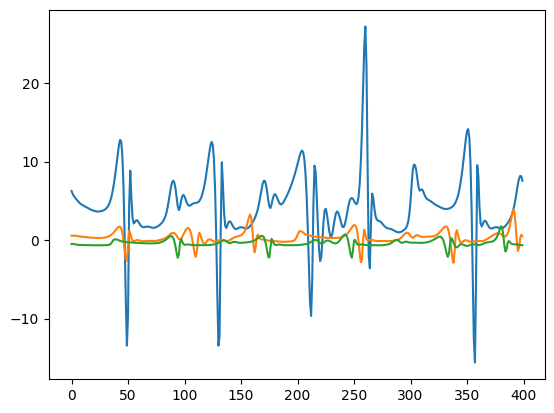

In [18]:
plt.plot(X_method_sim)

In [19]:
train_X = X_method_sim[:train_steps, :]
train_t = sim_t[:train_steps]

pred_method = method_type().fit(train_t, train_X)

test_X = X_method_sim[-test_steps - 1:, :]
test_t = sim_t[-test_steps - 1:]
test_X_pred = pred_method.predict(test_t, train_X, prior_t=train_t)

lightning_fabric.utilities.seed INFO  Seed set to 1
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
lightning_fabric.utilities.seed INFO  Seed set to 1
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs
pytorch_lightning.callbacks.model_summary INFO  
  | Name            | Type          | Params
----------------------

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, train_loss_step=0.0159, train_loss_epoch=0.0159]

pytorch_lightning.utilities.rank_zero INFO  `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, train_loss_step=0.0159, train_loss_epoch=0.0159]


/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
/Users/djpassey/Code/interfere/interfere/methods/nixtla_methods/nixtla_adapter.py:405: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  nf_data.ds = pd.to_datetime(nf_data.ds, unit='s', errors='coerce')
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.06it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.17it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.32it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.15it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.53it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.84it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.42it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.38it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.09it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.71it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.40it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.09it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.59it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.02it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.54it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.61it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.81it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.90it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.15it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.29it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.49it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.95it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.85it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.51it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.54it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.52it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.22it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.07it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.88it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.33it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.47it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
pytorch_lightning.utilities.rank_zero INFO  GPU available: False, used: False
pytorch_lightning.utilities.rank_zero INFO  TPU available: False, using: 0 TPU cores
pytorch_lightning.utilities.rank_zero INFO  IPU available: False, using: 0 IPUs
pytorch_lightning.utilities.rank_zero INFO  HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.10it/s]


/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


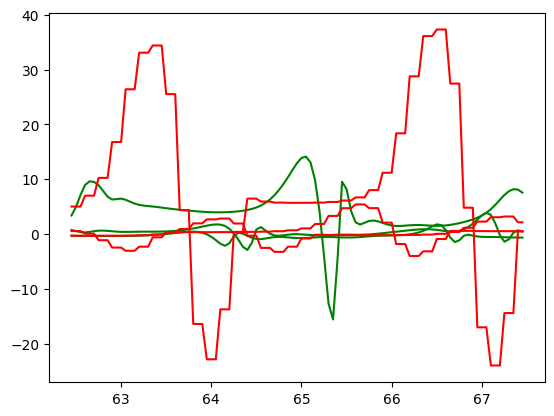

In [21]:
plt.plot(test_t, test_X, c="g")
plt.plot(test_t, test_X_pred, c="r")
plt.show()

In [1]:
import random 

class FishAgent:

    def __init__(
        self,
        name,
        eatPercent,
        poopPercent,
        peePercent,
        servingSize,
        weight,
        tankSize
    ):
        """Initializes a FishAgent object for aquarium simulation.
        
        Args:
            name (str): The name of the fish
            eatPercent (float): Controls probability that the fish eats during a
                timestep. 
            poopPercent (float): Controls probability that the fish poops during
                a timestep. 
            peePercent (float): Controls probability that the fish poops during
                a timestep. 
            servingSize (float): Used to compute the amount eaten in a timestep.
            weight (float): Weight of the fish in grams. Grows to 440 grams in 8
                months. 
            tankSize (float): Tank size in liters.
        """
        self.name = name
        self.eatPercent = eatPercent
        self.poopPercent = poopPercent
        self.peePercent = peePercent
        self.servingSize = servingSize
        self.weight = weight
        self.living = True
        self.status = 'Nothing'
        self.deadlyC1 = 2
        self.deadlyC3 = 5
        self.health = 86400 # A day in seconds
        self.tankSize = tankSize
    
    #these still need work, specifically in calculating the chemical changes

    def checkDeath(self,C1,C3):
        C1Conc = C1/self.tankSize
        C3Conc = C3/self.tankSize
        if (C1Conc) > self.deadlyC1 or (C3Conc) > self.deadlyC3:
            # Fish is taking damage C1 (mg/l): {C1Conc} C3 (mg/l): {C3Conc}
            self.health -= 1
            if self.health <= 0:
                #Fish health dropped below zero and is dying.
                self.living = False   
        return self.living
    
    def Eat(self):
        self.status = 'Eating'
        result = (self.weight*self.servingSize)
        return result
        
    def Poop(self):
        self.status = 'Pooping'
        result = (self.weight/3)
        self.weight -= result
        return result
        
    def Pee(self,t):
        self.status = 'Peeing'
        days = (t/3600)*24
        ratio = 0.00022046      # G ammonia per G fish per day
        result = self.weight * ratio * days
        return result
    
    def grow(self,t):
        GrowthRate = 13.75/(604800)    #Grows to 440 grams over 8 months
        if self.weight <= 440:
            self.weight += GrowthRate
            
    def getWeight(self):
        return self.weight

    def getAmmountEaten(self):
        return (self.servingSize / 326) # Converts the serving size to a normalized value on the plant biomass and returns it

    def action(self,t):
        fishActionProb = random.random()

        # Fish eats if the random number is in this range.
        if (fishActionProb >= 0.0) and (
            fishActionProb <= self.eatPercent):      
            result = self.Eat() 

        # Fish poops if the random number is in this range.
        elif (fishActionProb > self.eatPercent) and (
            fishActionProb <= self.poopPercent):
            result = self.Poop()

        # Fish pees if the random number is in this range
        elif (fishActionProb > self.poopPercent) and (
            fishActionProb <= self.peePercent):
            result = self.Pee(t) 
            
        else:
            #Otherwise the fish does nothing.
            result = 0
            self.status = "Nothing"
            
        return result,self.status
    

            
       


   

In [2]:
import matplotlib.pyplot as plt

def convert_seconds_to_weeks(seconds):
    dtWeeks = []
    for t in seconds:
        weeks = t/(604800)  # 604800 seconds in a week
        dtWeeks.append(weeks)
    return dtWeeks  

def plot_results(dC1, dC3, dC4, dT, number_of_fish, fish_population, production, tank_size, selfSufficient, duration, numFish, aC1, aC3, aC4,plantPopulation):
    plt.style.use('Solarize_Light2')  # Using a predefined style for nicer plots
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    #print(plt.style.available)
    

    # Chemical Change plots
    time_weeks = convert_seconds_to_weeks(dT)
    ax[0, 0].plot(time_weeks, dC1, label='Ammonia', color='tab:orange')
    ax[0, 0].plot(time_weeks, dC3, label='Nitrite', color='tab:red')
    ax[0, 0].plot(time_weeks, dC4, label='Nitrate', color='tab:green')
    ax[0, 0].legend(loc='upper right')
    ax[0, 0].set_title('Change in Chemicals Over Time', fontsize=14, fontweight='bold') 
    ax[0, 0].set_xlabel('Time (Weeks)', fontsize=12)
    ax[0, 0].set_ylabel('Change in Concentration (mg/L)', fontsize=12)

    # Calculating Total Production
    total_production = sum(fish.getWeight() for fish in fish_population)
    formatted_production = "{:.2f}".format(float(total_production))
    formatted_weeks = "{:.2f}".format(int(duration) / 604800)
    plantBiomass = ("{:.4f}".format( float(plantPopulation[0]) ))

    tankStatus = (f"\n\n\nAquaculture Tank Stats\n"
                  f"________________________________________\n\n\n"
                  f"Tank Size: {tank_size} Liters\n\n"
                  f"The Tank will Grow Harvestable Fish: {selfSufficient}\n\n"
                  f"Amount of Fish Produced (g): {formatted_production}\n\n"
                  f"Time Elapsed in Week(s): {formatted_weeks}\n\n"
                  f"Plant Biomass: {plantBiomass}\n\n")
                    
    
    # Fish Population Plot
    ax[1, 0].plot(time_weeks, numFish, label='Fish Population', color='tab:orange')
    ax[1, 0].set_title('Populations Over Time', fontsize=14, fontweight='bold')
    ax[1, 0].set_xlabel('Time (Weeks)', fontsize=12)
    ax[1, 0].set_ylabel('Population Size', fontsize=12)
    ax[1, 0].legend(loc='upper right')

    # Chemical Concentration Plots
    ax[0, 1].plot(time_weeks, aC1, label='Ammonia', color='tab:orange')
    ax[0, 1].plot(time_weeks, aC3, label='Nitrite', color='tab:red')
    ax[0, 1].plot(time_weeks, aC4, label='Nitrate', color='tab:green')
    # Add horizontal lines for deadly levels
    ax[0, 1].axhline(y=2, color='orange', linestyle='--', label='Deadly Ammonia Level')
    ax[0, 1].axhline(y=5, color='red', linestyle='--', label='Deadly Nitrite Level')
    ax[0, 1].legend(loc='upper right')
   

    # Add text labels for the horizontal lines
   
    ax[0, 1].set_title(f'Chemicals Concentration Over Time ({tank_size} Liters)', fontsize=14, fontweight='bold') 
    ax[0, 1].set_xlabel('Time (Weeks)', fontsize=12)
    ax[0, 1].set_ylabel('Concentration (mg/L)', fontsize=12)

    # Tank Status Text
    ax[1, 1].axis('off')
    ax[1, 1].text(0.410, 0.8681, tankStatus, fontsize=20, ha='center', va='center')

    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
import math





# Constants
Xmin = 0
Xmin = 0
Xmax = (24*math.pi)
Ymin = -(6*math.pi)
Ymax = (5* math.pi)
Zmin = (-6* math.pi)
Zmax = (2* math.pi)
Wishbone = (5 * pow(10,-6))
Wishbone1 = (2 * pow(10,-8))
Wishbone2 = (3 * pow(10,-6))
V = 4838400     # Period of time to run sim over before list is cleared
numV = 1        # Amount of times period of V is simulated 
tmin = 0


def p1(t):  # function for ammonia production
  step1 = np.arctan(t0(t))             
  step2 = step1 - np.arctan(t0(0))              
  step3 = Wishbone * step2
  return step3

p2 = pow(10,-4) # oxygen production within the aquarium
p3 = 0 # p3 nitrite consumtion 
p4 = (2* pow(10,-17)) # nitrate consumption 
q1 = (1/5) # constant limiting coefficient for ammonia growth
q2 = (1/8.5) # limiting coefficient for oxygen growth 

# inital p2 and p4 for calculation
p2i = p2
p4i = p4




# Define Functions


# Mu s, which represent efficiencies of different bacteria 
def mu1(t): #nitrosominous 
  result = Wishbone1*(np.arctan([t1(t)])-np.arctan([t1(tmin)]))
  return result
  
def mu2(t): # nitrobacter 
  result = Wishbone2*(np.arctan(t2(t))-np.arctan(t2(tmin)))
  return result

# t functions, act as constants in our equation, were described by paper  
def t0(t):
    return(((Xmax - Xmin) / V)*t + Xmin)

def t1(t):
    return(((Ymax - Ymin) / V)*t + Ymin)
    
def t2(t):
    return(((Zmax - Zmin) / V)*t + Zmin)  


# Change of concentration of Nitrate

def changeInAmmonia(t,C1,C2):
  step1 = p1(t) * (1 - ((q1) * C1))
  step2 = step1 - mu1(t) * ((C1 * C1) * (C2 * C2 * C2))
  concentrationChange = step2
  return concentrationChange

def changeInOxygen(t,C1,C2,C3):    # Change of Oxygen concentration over time 
    result = p2*(1-(q1)*(C2))-mu1(t)*pow(C1,2)*pow(C2,3)-mu2(t)*np.sqrt(C2)*C3
    return result
  
def changeInNitrite(t,C1,C2,C3):    # Change of Nitrite concentration over time 
    result = mu1(t)*(pow(C1,2))*(pow(C2,3))-mu2(t)*np.sqrt(C2)*C3-p3*C3
    return result

def changeInNitrate(t,C2,C3,C4):    # Change of Nitrate concentration over time 
  dt = 1
  dC4 = dt*(mu2(t)* np.sqrt(C2)*C3-(p4*C4))
  return dC4


   


#======================================================================================================================================
# Sim Function 
#======================================================================================================================================
def simulation(tank_size, number_of_fish, duration, production, save_log, fish_list):
    print("=============================================================================================================================")
    print("\n\n")
    print("                              Agent-Based Continuous-Time Simulation of Aquaculture Systems                                     ")
    print("                           Written By: Alex Puskaric, Devon Godde, Elijah Muzzi, Jacob Sinclair                                 ") 
    print("\n")
    print("=============================================================================================================================")
    print("\n\nStarting Simulation...\n\n")


    # Plant Biomass List
    plantPopulation = [0.5, (0.00000019*1)] # Normalized Plant Biomass, Growth Rate per Second

    # Constants
    fish_population = fish_list
    V = int(duration)
    dt = 1
    dead_fish = []
    numFish = []
    

   
    # Reset chemical concentrations for each simulation run
    C1, C2, C3, C4 = 0, 8.5, 0, 0
    C1i, C2i, C3i, C4i = 0, 8.5, 0, 0
    dC1, dC2, dC3, dC4, dT = [], [], [], [], []
    aC1,aC2,aC3,aC4 = [],[],[],[]
    log = []
    selfSufficient = True


    for t in range(V):
        for fish in fish_population:
            index = fish_population.index(fish) + 1
            action_result, status = fish.action(t)
            if status == 'Eating':
                if save_log:
                    log.append(f"{fish.name} is eating at time {t} seconds\n")
                plantPopulation[0] = plantPopulation[0] - fish.getAmmountEaten()
                # Modify chemicals accordingly
                
            elif status == 'Pooping':
                #C1 += action_result  # Assuming action_result is the increase in Ammonia
                if save_log:
                    log.append(f"{fish.name} is pooping at time {t} seconds\n")
            elif status == 'Peeing':
                if save_log:
                    log.append(f"{fish.name} is peeing at {t} seconds\n")
                # Modify chemicals accordingly
                C1 += action_result
            fish.grow(t)
            if not fish.checkDeath(C1,C3):
                if save_log:
                    log.append(f"{fish.name} has died at {t} seconds at C1 (mg/L) {C1/tank_size} & C3 (mg/L) {C3/tank_size}\n")
                selfSufficient = False
                fish_population.remove(fish)
                dead_fish.append(fish)
        
    

        # If plant biomass is greater than max, set it to max
        if((plantPopulation[0] + plantPopulation[1]) >= 1):
            plantPopulation[0] = 1
        # If plant biomass is at or less than 0, keep it at 0
        elif(plantPopulation[0] <= 0):
            plantPopulation[0] = 0
        # Otherwise, grow
        elif(plantPopulation[0] > 0):
            plantPopulation[0] = plantPopulation[0] + plantPopulation[1]

        p2 = p2i * (0.5 + plantPopulation[0])
        p4 = p4i * (0.5 + plantPopulation[0])  

        C1 += changeInAmmonia(t,C1,C2)
        C2 += changeInOxygen(t,C1,C2,C3)
        C3 += changeInNitrite(t,C1,C2,C3)
        C4 += changeInNitrate(t,C2,C3,C4)

        dC1.append(C1 - C1i)
        dC3.append(C3 - C3i)
        dC4.append(C4 - C4i)
        
        aC1.append((C1/tank_size))
        aC3.append((C3/tank_size))
        aC4.append((C4/tank_size))
        dT.append(t)
        numFish.append(len(fish_population))

            
            
    plot_results(dC1, dC3, dC4, dT, number_of_fish, fish_population, production, tank_size,selfSufficient,V,numFish,aC1,aC3,aC4,plantPopulation)


In [4]:
def start_simulation(
        tank_size: float,
        fish_weights: np.ndarray,
        duration: int
    ):
    """
    
    Args:
        tanks_size (float): Size of fish tank in liters.
        fish_weights (float): Weights of the fish in grams.
        duration (int): Number of seconds to simulate.
    """

    number_of_fish = len(fish_weights)
    fish_population = [
        FishAgent(
            f'Tilapia{i}',
            0.0000069,
            0.0000104,
            0.0000173,
            0.02,
            fish_weights[i],
            tank_size
        ) for i in range(number_of_fish)
    ]
    simulation(
        tank_size,
        number_of_fish,
        duration, 
        production=0,
        save_log=False,
        fish_list=fish_population
    )





                              Agent-Based Continuous-Time Simulation of Aquaculture Systems                                     
                           Written By: Alex Puskaric, Devon Godde, Elijah Muzzi, Jacob Sinclair                                 




Starting Simulation...




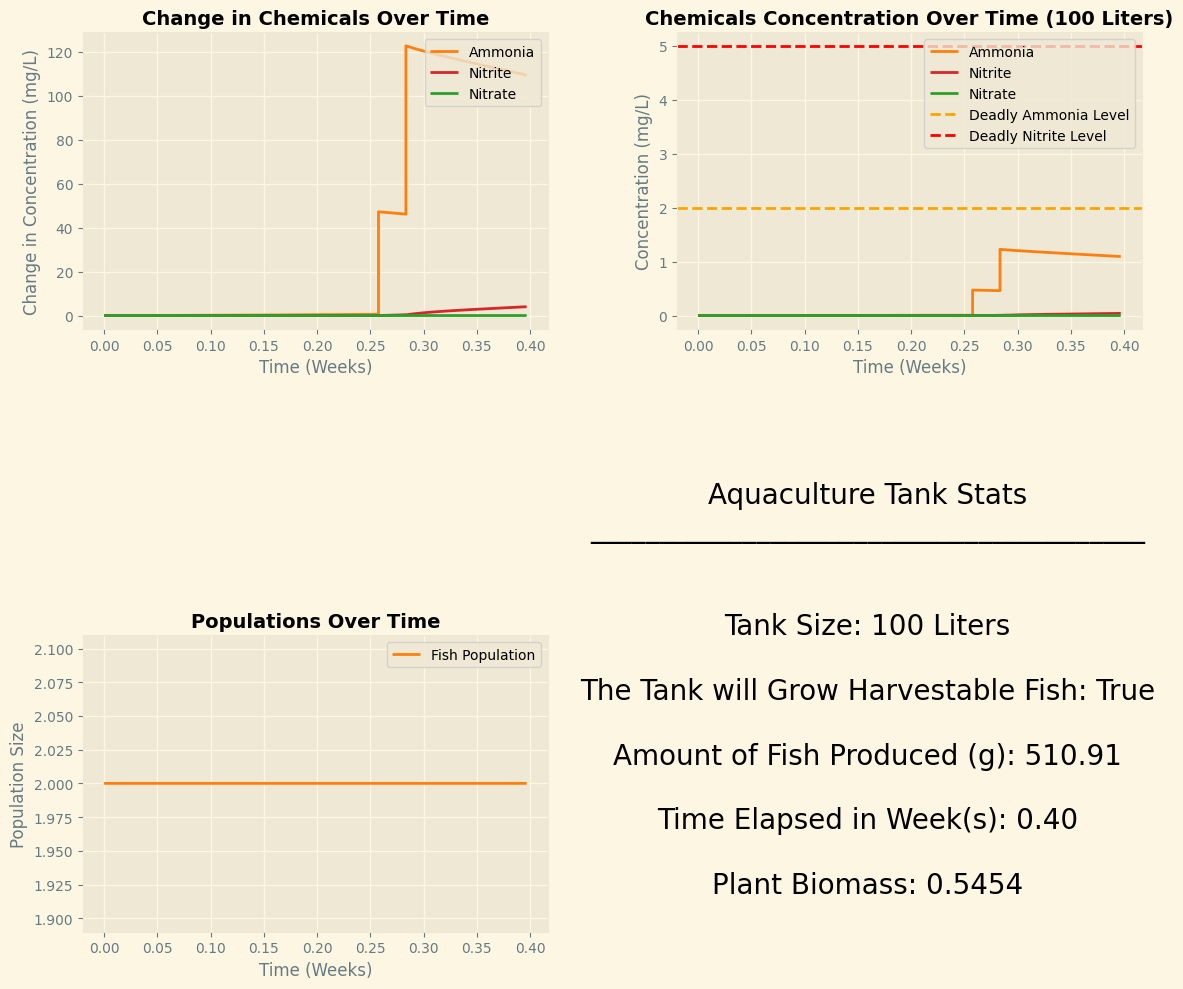

In [8]:
start_simulation(100, [200, 300], 240_000)




                              Agent-Based Continuous-Time Simulation of Aquaculture Systems                                     
                           Written By: Alex Puskaric, Devon Godde, Elijah Muzzi, Jacob Sinclair                                 




Starting Simulation...




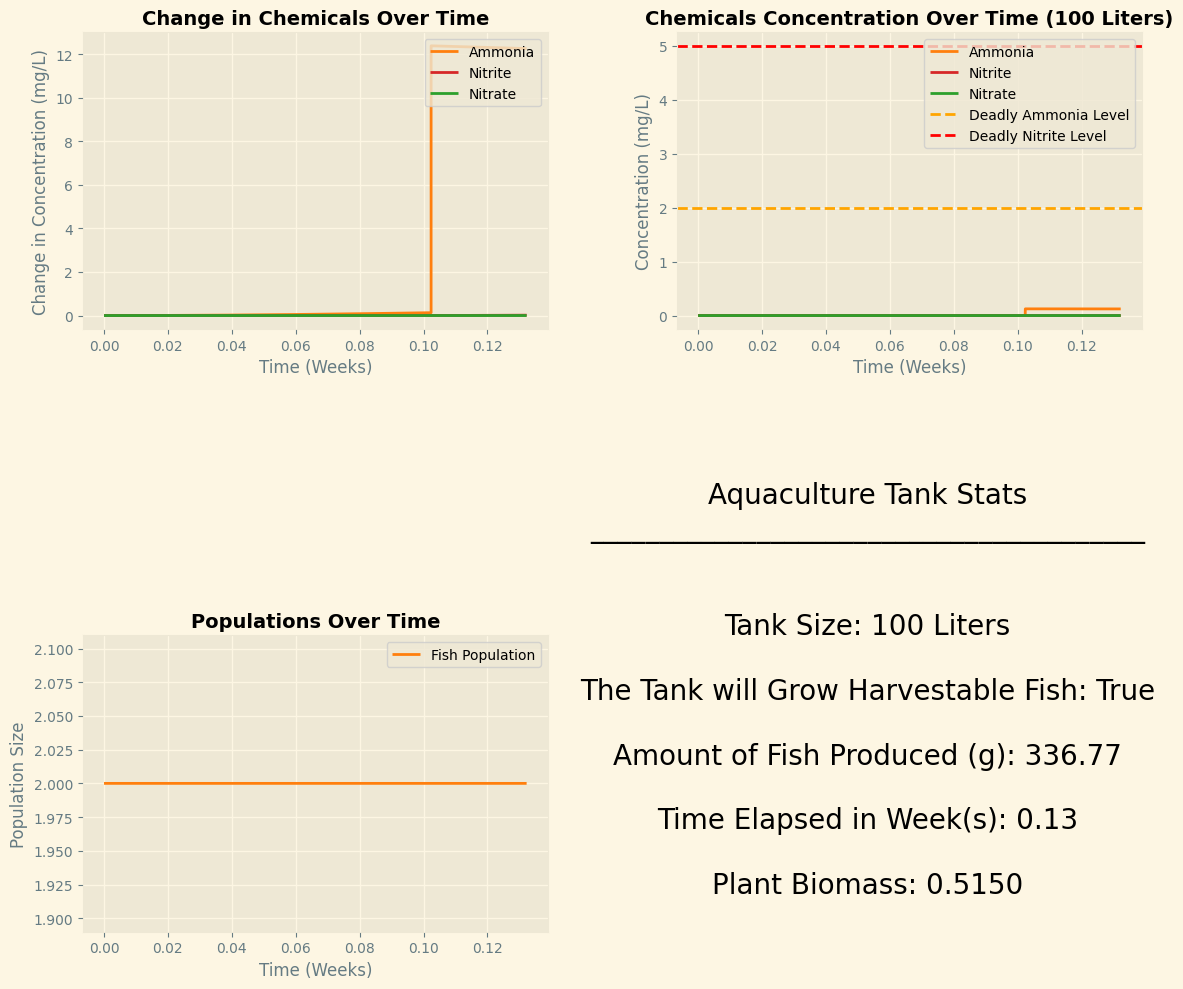

         4813220 function calls (4788363 primitive calls) in 11.358 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   160000    1.238    0.000    1.238    0.000 2386190858.py:45(checkDeath)
        2    0.000    0.000    0.000    0.000 2386190858.py:5(__init__)
        3    0.000    0.000    0.000    0.000 2386190858.py:56(Eat)
        2    0.000    0.000    0.000    0.000 2386190858.py:61(Poop)
        1    0.000    0.000    0.000    0.000 2386190858.py:67(Pee)
   160000    0.071    0.000    0.071    0.000 2386190858.py:74(grow)
        2    0.000    0.000    0.000    0.000 2386190858.py:79(getWeight)
        3    0.000    0.000    0.000    0.000 2386190858.py:82(getAmmountEaten)
   160000    0.159    0.000    0.187    0.000 2386190858.py:85(action)
        1    0.000    0.000    1.386    1.386 2705075836.py:10(plot_results)
        3    0.000    0.000    0.000    0.000 2705075836.py:28(<genexpr>)
        1    0.016    0.

In [9]:
import cProfile

cProfile.run("start_simulation(100, [200, 300], 80_000)")

In [11]:
import numpy as np

REFERENCE_TIME_V = 6 * 7 * 24 * 60 * 60  # 6 Weeks * Days * Hours * Min * Sec.
T_MIN = 0

AMMONIA_EFF_GAMMA = 5e-6
AMMINIA_MAX_C1 = 5
AMMONIA_LIMIT_Q1 = 1 / AMMINIA_MAX_C1  
AMMONIA_EFF_X_MIN = 0.0
AMMONIA_EFF_X_MAX = 24 * np.pi
AMMONIA_EFF_CONST = np.arctan(AMMONIA_EFF_X_MIN)

OXY_PROD_P2 = 1e-4
OXY_MAX_C2 = 8.5
OXY_LIMIT_Q2 = 1 / OXY_MAX_C2

NITRITE_CONS_P3 = 0
NITRATE_CONS_P4 = 2e-7

NITRITE_BACT_EFF_GAMMA1 = 2e-8
NITRITE_BACT_EFF_Y_MIN = -6 * np.pi
NITRITE_BACT_EFF_Y_MAX = 5 * np.pi
NITIRITE_BACT_EFF_CONST = np.arctan((NITRITE_BACT_EFF_Y_MAX - NITRITE_BACT_EFF_Y_MIN) * T_MIN / REFERENCE_TIME_V + NITRITE_BACT_EFF_Y_MIN)
    

NITRATE_BACT_EFF_GAMMA2 = 3e-6
NITRATE_BACT_EFF_Z_MIN = -6 * np.pi
NITRATE_BACT_EFF_Z_MAX = 2 * np.pi
NITRATE_BACT_EFF_CONST = np.arctan((NITRATE_BACT_EFF_Z_MAX - NITRATE_BACT_EFF_Z_MIN) * T_MIN / REFERENCE_TIME_V + NITRATE_BACT_EFF_Z_MIN)
    
# Efficiency function models.

# p1 in paper.
ammon_prod_eff_p1 = lambda t: AMMONIA_EFF_GAMMA * (np.arctan((AMMONIA_EFF_X_MAX - AMMONIA_EFF_X_MIN) * t / REFERENCE_TIME_V + AMMONIA_EFF_X_MIN) - AMMONIA_EFF_CONST) 

# mu1 in the paper. 
nitrite_bacteria_effic_mu1 = lambda t: NITRITE_BACT_EFF_GAMMA1 * (np.arctan((NITRITE_BACT_EFF_Y_MAX - NITRITE_BACT_EFF_Y_MIN) * t / REFERENCE_TIME_V + NITRITE_BACT_EFF_Y_MIN) - NITIRITE_BACT_EFF_CONST)

# mu2 in paper.
nitrate_bacteria_effic_mu2 = lambda t: NITRATE_BACT_EFF_GAMMA2 * (np.arctan((NITRATE_BACT_EFF_Z_MAX - NITRATE_BACT_EFF_Z_MIN) * t / REFERENCE_TIME_V + NITRATE_BACT_EFF_Z_MIN) - NITRATE_BACT_EFF_CONST)




def nitrogen_cycle_derivative(x: np.ndarray, t: float):
    """"""
    ammonia, oxy, nitrite, nitrate = x
    
    d_ammonium_dt = ammon_prod_eff_p1(t) * (1 - AMMONIA_LIMIT_Q1 * ammonia) - nitrite_bacteria_effic_mu1(t) * ammonia **2 * oxy ** 3

    d_oxy_dt = OXY_PROD_P2 * (1 - OXY_LIMIT_Q2 * oxy ) - nitrite_bacteria_effic_mu1(t) * ammonia **2 * oxy ** 3 - nitrate_bacteria_effic_mu2(t) * oxy ** 0.5 * nitrite

    d_nitrite_dt = nitrite_bacteria_effic_mu1(t) * ammonia **2 * oxy ** 3 - nitrate_bacteria_effic_mu2(t) * oxy ** 0.5 * nitrite - NITRITE_CONS_P3 * nitrite

    d_nitrate_dt = nitrate_bacteria_effic_mu2(t) * oxy ** 0.5 * nitrite - NITRATE_CONS_P4 * nitrate

    return np.array([d_ammonium_dt, d_oxy_dt, d_nitrite_dt, d_nitrate_dt])



In [4]:
import matplotlib.pyplot as plt

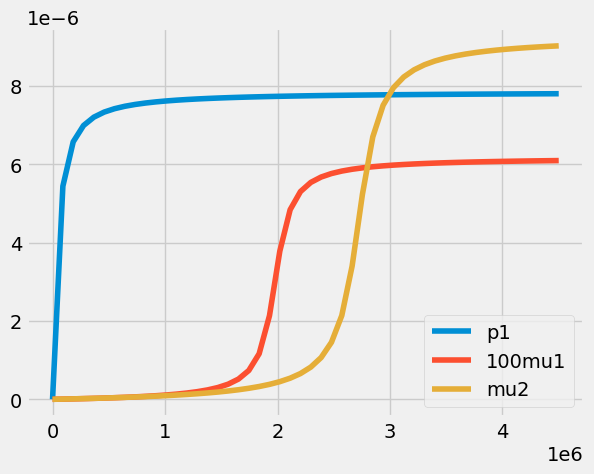

In [7]:
plt.style.use('fivethirtyeight')

t_vals = np.linspace(0, 4.5e6)
plt.plot(t_vals, ammon_prod_eff_p1(t_vals), label="p1")
plt.plot(t_vals, 100 * nitrite_bacteria_effic_mu1(t_vals), label="100mu1")
plt.plot(t_vals, nitrate_bacteria_effic_mu2(t_vals), label="mu2")


plt.legend()

In [12]:
from scipy.integrate import odeint

T_MAX = 5_000_000
x0 = np.array([0, 8.5, 0, 0])
t_vals = np.linspace(0, T_MAX, 1000)

X = odeint(nitrogen_cycle_derivative, x0, t_vals)

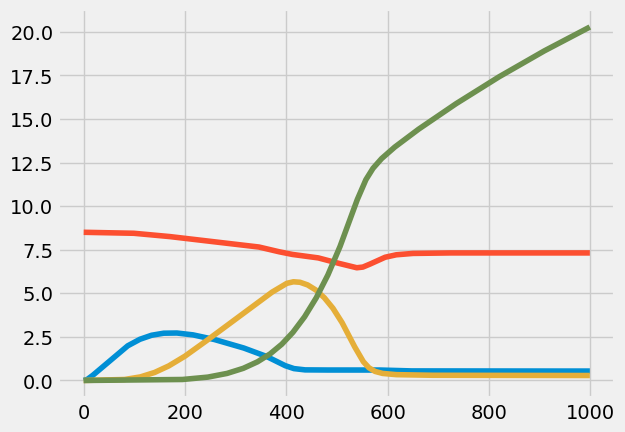

In [13]:
plt.plot(X)

In [1]:
import interfere

/Users/djpassey/Code/interfere/venv_interfere/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = interfere.dynamics.PlantedTankNitrogenCycle.__name__

In [8]:
PlantedTankNitrogenCycle()

TypeError: __init__() missing 1 required positional argument: 'dim'